# Break through the reCAPTCHA

### Taeho KIM, Kyung Hee UNIV. <a href="https://github.com/HwangToeMat">GitHub 주소</a>

In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long


class NodeLookup(object):
    """Converts integer node ID's to human readable labels."""

    def __init__(self,
                 label_lookup_path=None,
                 uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(
                'model', 'imagenet_2012_challenge_label_map_proto.pbtxt')
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(
                'model', 'imagenet_synset_to_human_label_map.txt')
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.

        Args:
          label_lookup_path: string UID to integer node ID.
          uid_lookup_path: string UID to human-readable string.

        Returns:
          dict from integer node ID to human-readable string.
        """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)

        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
            node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


def create_graph():
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(os.path.join(
            'model', 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')


def run_inference_on_image(image):
    """Runs inference on an image.

    Args:
      image: Image file name.

    Returns:
      Nothing
    """
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()

    # Creates graph from saved GraphDef.
    create_graph()

    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
        predictions = sess.run(softmax_tensor,
                               {'DecodeJpeg/contents:0': image_data})
        predictions = np.squeeze(predictions)

        # Creates node ID --> English string lookup.
        node_lookup = NodeLookup()

        top_k = predictions.argsort()[-5:][::-1]
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)' % (human_string, score))


def maybe_download_and_extract():
    """Download and extract model tar file."""
    dest_directory = 'model'
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
                filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

## load model
- default model >>
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

- any model you want >>
DATA_URL = 'XXX'

In [2]:
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
maybe_download_and_extract()

## image classification

In [3]:
import PIL.Image as pilimg

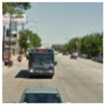

In [4]:
img= pilimg.open('image/reCAPTCHA1.png')
img

In [5]:
run_inference_on_image('image/reCAPTCHA1.png')

W0223 01:34:04.827322 16884 deprecation.py:323] From <ipython-input-1-0fd8df8e7765>:120: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


moving van (score = 0.73877)
golfcart, golf cart (score = 0.04019)
mobile home, manufactured home (score = 0.01723)
trolleybus, trolley coach, trackless trolley (score = 0.01485)
recreational vehicle, RV, R.V. (score = 0.01232)


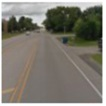

In [6]:
img= pilimg.open('image/reCAPTCHA2.png')
img

In [7]:
run_inference_on_image('image/reCAPTCHA2.png')

trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi (score = 0.26690)
seashore, coast, seacoast, sea-coast (score = 0.08148)
screen, CRT screen (score = 0.06434)
moving van (score = 0.04228)
mobile home, manufactured home (score = 0.03318)


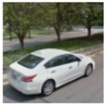

In [8]:
img= pilimg.open('image/reCAPTCHA3.png')
img

In [9]:
run_inference_on_image('image/reCAPTCHA3.png')

minivan (score = 0.27316)
limousine, limo (score = 0.15485)
convertible (score = 0.03864)
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (score = 0.03772)
moving van (score = 0.03242)


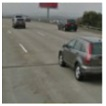

In [10]:
img= pilimg.open('image/reCAPTCHA4.png')
img

In [11]:
run_inference_on_image('image/reCAPTCHA4.png')

airliner (score = 0.09025)
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi (score = 0.08313)
traffic light, traffic signal, stoplight (score = 0.08120)
minivan (score = 0.07874)
tow truck, tow car, wrecker (score = 0.05683)


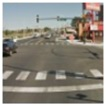

In [12]:
img= pilimg.open('image/reCAPTCHA5.png')
img

In [13]:
run_inference_on_image('image/reCAPTCHA5.png')

seashore, coast, seacoast, sea-coast (score = 0.29206)
aircraft carrier, carrier, flattop, attack aircraft carrier (score = 0.08607)
lakeside, lakeshore (score = 0.06951)
airliner (score = 0.05057)
mobile home, manufactured home (score = 0.03011)


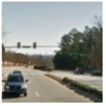

In [14]:
img= pilimg.open('image/reCAPTCHA6.png')
img

In [15]:
run_inference_on_image('image/reCAPTCHA6.png')

moving van (score = 0.18085)
seashore, coast, seacoast, sea-coast (score = 0.15978)
mobile home, manufactured home (score = 0.11563)
steel arch bridge (score = 0.04356)
worm fence, snake fence, snake-rail fence, Virginia fence (score = 0.03528)


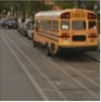

In [16]:
img= pilimg.open('image/reCAPTCHA7.png')
img

In [17]:
run_inference_on_image('image/reCAPTCHA7.png')

school bus (score = 0.94535)
amphibian, amphibious vehicle (score = 0.00103)
trolleybus, trolley coach, trackless trolley (score = 0.00101)
passenger car, coach, carriage (score = 0.00091)
streetcar, tram, tramcar, trolley, trolley car (score = 0.00088)


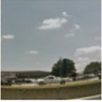

In [18]:
img= pilimg.open('image/reCAPTCHA8.png')
img

In [19]:
run_inference_on_image('image/reCAPTCHA8.png')

seashore, coast, seacoast, sea-coast (score = 0.23562)
sandbar, sand bar (score = 0.10286)
yawl (score = 0.07008)
airliner (score = 0.03950)
promontory, headland, head, foreland (score = 0.02806)


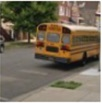

In [20]:
img= pilimg.open('image/reCAPTCHA9.png')
img

In [21]:
run_inference_on_image('image/reCAPTCHA9.png')

school bus (score = 0.92765)
moving van (score = 0.00156)
trolleybus, trolley coach, trackless trolley (score = 0.00152)
tobacco shop, tobacconist shop, tobacconist (score = 0.00088)
thresher, thrasher, threshing machine (score = 0.00087)
